<h1>KNN Exploration</h1>
This notebook will contain Erika's contribution to the assignment. To start with, Erika will look at using KNN on the Kickstarter data.

It will use the split data shared between us for test/validate/train that was produced by the datasplit notebook, and will follow a standard cleaning convention.

In [87]:
# Load necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# For KNN stuff
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [88]:
# Taken from Michael's notebook
def preprocess_df(df):
    df["deadline"] = pd.to_datetime(df["deadline"])
    df["launched"] = pd.to_datetime(df["launched"])
    df["success"] = df["pledged"] >= df["goal"]
    df["duration"] = df["deadline"] - df["launched"]
    
    return df

In [89]:
# Taken from Michael's notebook
def clean_df(df):
    df = df.drop(df.loc[df["duration"] < datetime.timedelta(days=1)].index)
    df = df.drop(df.loc[df["state"] == "live"].index)
    df = df.drop(df.loc[df["state"] == "canceled"].index)
    
    return df

In [90]:
# Taken from Michael's notebook
train_full = pd.read_csv("data/2018-train.csv").dropna()
validate_full = pd.read_csv("data/2018-validate.csv").dropna()

In [91]:
# Taken from Michael's notebook
train_pp = preprocess_df(train_full)
validate_pp = preprocess_df(validate_full)

In [92]:
# Taken from Michael's notebook
train_clean = clean_df(train_pp)
validate_clean = clean_df(validate_pp)
train_clean.head()

,Unnamed: 0,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,success,duration
0,319122,695425648,Peace-building through story-making with youth...,Children's Books,Publishing,SEK,2015-06-09,6000.0,2015-05-10 14:53:53,6251.0,successful,15,SE,756.92,762.02,731.42,True,29 days 09:06:07
2,175494,189251239,Colored Baggies for Boardgames,Tabletop Games,Games,USD,2013-01-07,6000.0,2012-11-08 20:06:31,15151.0,successful,518,US,15151.00,15151.00,6000.00,True,59 days 03:53:29
4,141771,1720248225,Two Scoops of Beauty health wellness women eve...,Events,Food,USD,2016-09-04,5202.0,2016-08-05 01:26:56,0.0,failed,0,US,0.00,0.00,5202.00,False,29 days 22:33:04
5,236644,272982453,Gavarcia - Haute Couture in Canada,Couture,Fashion,CAD,2015-04-16,3000.0,2015-03-18 16:27:44,556.0,failed,8,CA,434.86,456.07,2460.83,False,28 days 07:32:16
6,231360,245912004,"""One Last Crazy F*cking Night"" (#OLCFN) The Movie",Narrative Film,Film & Video,USD,2013-03-01,50000.0,2013-01-30 17:55:02,3041.0,failed,28,US,3041.00,3041.00,50000.00,False,29 days 06:04:58


In [93]:
def prep_knn_basic(df):
    
    X = df[["usd_goal_real", "duration"]].copy()
    # TODO: eventually we'll want to care about text fields
    
    # Transform fields
    X["duration"] = X["duration"].apply(lambda x: x.seconds)
    
    # Extract basic time features for launched and deadline
    X["launched_month"] = df["launched"].apply(lambda x: x.month)
    X["launched_hour"] = df["launched"].apply(lambda x: x.hour)
    X["deadline_month"] = df["deadline"].apply(lambda x: x.month)
    X["deadline_hour"] = df["deadline"].apply(lambda x: x.hour)
    
    # TODO: extract text features
    
    y = df["success"].copy()
    
    return X, y

In [94]:
# Start by looking at scikit learn nearest neightbors

def try_knn(X_train, y_train, X_validate, y_validate, neighbors, weights, algorithm='auto'):
    knn = KNeighborsClassifier(n_neighbors=neighbors, weights=weights, algorithm=algorithm)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_validate)
    return knn, metrics.accuracy_score(y_validate, y_pred)

In [95]:
def get_scores(n_low, n_high, n_step, X_train, y_train, X_validate, y_validate, weights=['uniform', 'distance']):
    max_score = (0, None, None, None)
    scores = {}
    for w in weights:
        print("Looking at weight measurement: {}".format(w))
        scores["{}".format(w)] = []
        for n in range(n_low, n_high, n_step):
            knn, score = try_knn(X_train, y_train, X_validate, y_validate, neighbors=n, weights=w)
            if (n % 5 == 0):
                print("\tFor {: 2} neighbors, score: {}".format(n, score))
            scores["{}".format(w)].append((n, score))
            if max_score[0] < score:
                max_score = (score, w, n, knn)
    return max_score, scores

In [96]:
def plot_scores(scores):
    fig, ax = plt.subplots()
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'black']

    for i, (key, score_array) in enumerate(scores.items()):
        ns = [n for (n, _) in score_array]
        ss = [s for (_, s) in score_array]
        line, = ax.plot(ns, ss, color=colors[i])
        line.set_label(key)
    
    # Label axes
    ax.set(xlabel='Number of neighbors', ylabel='Score',
           title='A graph plotting number of neighbors and scores')

    ax.legend()
    plt.show()

In [105]:
X_train, y_train = prep_knn_basic(train_clean)
X_validate, y_validate = prep_knn_basic(validate_clean)
X_train.head()

,usd_goal_real,duration,launched_month,launched_hour,deadline_month,deadline_hour
0,731.42,32767,5,14,6,0
2,6000.00,14009,11,20,1,0
4,5202.00,81184,8,1,9,0
5,2460.83,27136,3,16,4,0
6,50000.00,21898,1,17,3,0


Looking at weight measurement: uniform
	For  100 neighbors, score: 0.6091311016872688
	For  200 neighbors, score: 0.6125297001413577
	For  300 neighbors, score: 0.6103642214803453
	For  400 neighbors, score: 0.6118379500135342
	For  500 neighbors, score: 0.6122890914012451
	For  600 neighbors, score: 0.6110258955156546
	For  700 neighbors, score: 0.6131011458991248
	For  800 neighbors, score: 0.6124996240488436
	For  900 neighbors, score: 0.6114469608108515
	For  1000 neighbors, score: 0.6106349063129718
	For  1100 neighbors, score: 0.6106349063129718
	For  1200 neighbors, score: 0.6103642214803453
	For  1300 neighbors, score: 0.611747721735992
	For  1400 neighbors, score: 0.6126500045114138
	For  1500 neighbors, score: 0.6123191674937593
	For  1600 neighbors, score: 0.6118379500135342
	For  1700 neighbors, score: 0.611717645643478
	For  1800 neighbors, score: 0.6126199284188998
	For  1900 neighbors, score: 0.6129507654365545
	For  2000 neighbors, score: 0.6134921351018076
	For  2100 n

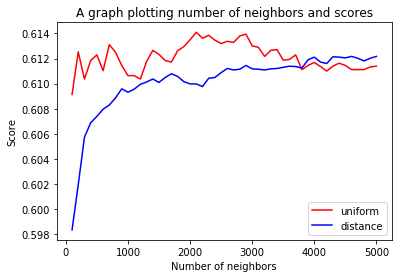

In [106]:
max_score, scores = get_scores(100, 5001, 100, X_train, y_train, X_validate, y_validate, weights=['uniform', 'distance'])
print("The max score is: {} (w={}, n={})".format(max_score[0], max_score[1], max_score[2]))
plot_scores(scores)

In [111]:
def prep_knn(df):
    
    X = df[["usd_goal_real", "duration"]].copy()
    # TODO: eventually we'll want to care about text fields
    
    # Transform fields
    X["duration"] = X["duration"].apply(lambda x: x.seconds)
    
    # Extract basic time features for launched and deadline
    X["launched_month"] = df["launched"].apply(lambda x: x.month)
    X["launched_hour"] = df["launched"].apply(lambda x: x.hour)
    X["deadline_month"] = df["deadline"].apply(lambda x: x.month)
    # This looks like it may not be super helpful. Not a lot of variety.
    # X["deadline_hour"] = df["deadline"].apply(lambda x: x.hour)
    
    # TODO: extract VERY BASIC text features of name
    X["name_chars"] = df["name"].apply(lambda x: len(set(x)))
    X["name_len"] = df["name"].apply(lambda x: len(x))
    
    # transform the category column into codes -> 
    # some problems here, as this will number some columns as closer than others.
    X["main_category_code"] = df["main_category"].astype('category').cat.codes
    X["category_code"] = df["category"].astype('category').cat.codes
    
    y = df["success"].copy()
    
    return X, y

In [112]:
X_train, y_train = prep_knn(train_clean)
X_validate, y_validate = prep_knn(validate_clean)
X_train.head()

,usd_goal_real,duration,launched_month,launched_hour,deadline_month,name_chars,name_len,main_category_code,category_code
0,731.42,32767,5,14,6,23,56,12,19
2,6000.00,14009,11,20,1,14,30,8,136
4,5202.00,81184,8,1,9,23,60,7,44
5,2460.83,27136,3,16,4,16,34,5,31
6,50000.00,21898,1,17,3,28,49,6,93


There are 249956 samples
Looking at weight measurement: uniform
	For  1800 neighbors, score: 0.6127402327889561
	For  1825 neighbors, score: 0.612228939216217
	For  1850 neighbors, score: 0.6128605371590123
	For  1875 neighbors, score: 0.6125898523263857
	For  1900 neighbors, score: 0.6131612980841529
	For  1925 neighbors, score: 0.6125898523263857
	For  1950 neighbors, score: 0.6123793196787873
	For  1975 neighbors, score: 0.6133116785467232
	For  2000 neighbors, score: 0.61373274384192
	For  2025 neighbors, score: 0.6135823633793498
	For  2050 neighbors, score: 0.6138229721194622
	For  2075 neighbors, score: 0.61373274384192
	For  2100 neighbors, score: 0.6141538091371169
	For  2125 neighbors, score: 0.6139733525820326
	For  2150 neighbors, score: 0.6139733525820326
	For  2175 neighbors, score: 0.6134620590092935
The max score is: 0.6141538091371169 (w=uniform, n=2100)


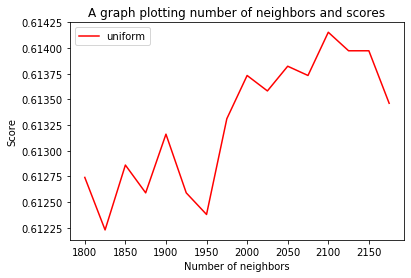

In [113]:
print("There are {} samples".format(len(X_train)))
max_score, scores = get_scores(1800, 2200, 25, X_train, y_train, X_validate, y_validate, weights=['uniform'])
print("The max score is: {} (w={}, n={})".format(max_score[0], max_score[1], max_score[2]))
plot_scores(scores)